In [1]:
%run ../../../utils/commonImports.py
%run ../../../utils/tradingImports.py
%matplotlib inline

from base import supres
from exputils import *

# Load data

In [10]:
# dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'
features = ['change_1', 'change_2', 'change_3']
pairs = read_tsv('selected-pairs.tsv', header=None)[0].tolist()

data__dict = {p: read_all(p, dropbox_dir) for p in pairs}
supports = read_tsv('featured.tsv')

In [3]:
window_sizes = [4]
shifts = [1, 2, 3]

DAY = 48
max_hold_time = 5 * DAY
stop_loss = 0.05
fee = 0.0025

In [90]:
def select_supports(supports, pair, win_size):
    return supports.query(f'pair == "{pair}"')\
        .query(f'win_size == {win_size}')\
        .sort_values('date')\
        .copy()\
        .values

def supports_dict(data):
    return {pair: {w: select_supports(data, pair, w) for w in window_sizes} for pair in pairs}

supports_dict = supports_dict(supports)
columns_dict = {col: i for i, col in enumerate(supports.columns)}

# Get features to OHLC

In [200]:
from itertools import product

features = ['support', 'change_1', 'change_2', 'change_3']
features_idxs = [columns_dict[col] for col in features]

def find_features(i, supports):
    selected = supports[supports[:, columns_dict['index']] <= i, :][:, features_idxs]
    return [None] * len(features) if len(selected) == 0 else selected[-1, :].tolist()


def ohlc_features_f(args):
    pair, window_size, i = args
    supports = supports_dict[pair][window_size]
    data = data_dict[pair]
    return pair, window_size, i, find_features(i, supports)


def get_features_dict(results):
    df = pd.DataFrame(results, columns=['pair', 'win_size', 'i', 'features'])
    results_dict = {}
    for pair in df['pair'].drop_duplicates():
        pair_dict = results_dict.get(pair, {})
        for win_size in df['win_size'].drop_duplicates():
            selected = df.query(f'pair == "{pair}"')\
                .query(f'win_size == {win_size}')\
                .sort_values('i')\
                ['features']\
                .tolist()
            pair_dict[win_size] = pd.DataFrame(selected, columns=features)
        results_dict[pair] = pair_dict
    return results_dict

def calc_ohlc_features(data_dict, supports_dict, output_file):
    args = []
    for pair in pairs:
        data = data_dict[pair]
        args += list(product([pair], window_sizes, list(range(len(data)))))
    
    results = run_parallel(ohlc_features_f, args, n_process=20)
    features_for_data_dict = get_features_dict(results)
    save_model(features_for_data_dict, output_file)

In [201]:
calc_ohlc_features(data_dict, supports_dict, 'ohlc_featured.pkl')

# Test

In [202]:
def plot_ohlc_with_points(ohlc):    
    plot_candles(ohlc);
    min_i, max_i = ohlc['index'].min(), ohlc['index'].max()
    plt.scatter(range(len(ohlc)), ohlc['support'], c='b')

In [203]:
pair = 'BTC_VTC'
data = data_dict[pair]
data[features] = load_model('ohlc_featured.pkl')[pair][4]

In [204]:
data.tail()

,timestamp,period,open,high,low,close,volume,quoteVolume,weightedAverage,date,ohlc4,support,change_1,change_2,change_3
56923,1554067800,30min,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0001,2019-03-31 21:30:00,0.0001,0.0001,-0.0040,0.0151,0.0128
56924,1554069600,30min,0.0001,0.0001,0.0001,0.0001,0.0043,33.4672,0.0001,2019-03-31 22:00:00,0.0001,0.0001,-0.0040,0.0151,0.0128
56925,1554071400,30min,0.0001,0.0001,0.0001,0.0001,0.0220,171.1623,0.0001,2019-03-31 22:30:00,0.0001,0.0001,-0.0040,0.0151,0.0128
56926,1554073200,30min,0.0001,0.0001,0.0001,0.0001,0.2024,"1,578.4892",0.0001,2019-03-31 23:00:00,0.0001,0.0001,-0.0040,0.0151,0.0128
56927,1554075000,30min,0.0001,0.0001,0.0001,0.0001,0.0088,68.7803,0.0001,2019-03-31 23:30:00,0.0001,0.0001,-0.0040,0.0151,0.0128


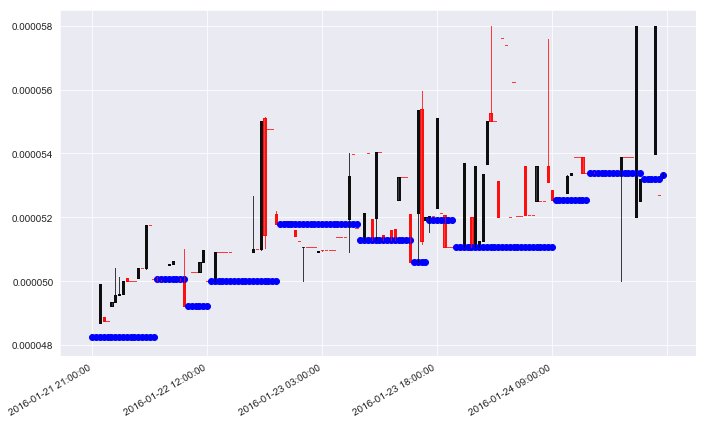

In [205]:
step = 150
for i in range(1000, len(data), step):
    to_plot = data.iloc[i:i+step].reset_index()
    plot_ohlc_with_points(to_plot)
    break

In [145]:
def plot_ohlc_with_points(ohlc, s):
    def plot_points(points, c):
        points_s = points[(points[:, 0] >= min_i) & (points[:, 0] <= max_i)]
        plt.scatter(points_s[:, 0] - min_i, points_s[:, 1], s=150, c=c);
        
    plot_candles(ohlc);
    min_i, max_i = ohlc['index'].min(), ohlc['index'].max()
    plot_points(s, 'b')

In [139]:
supports = read_tsv('featured.tsv')

In [150]:
s = supports.query(f'pair == "{pair}"')

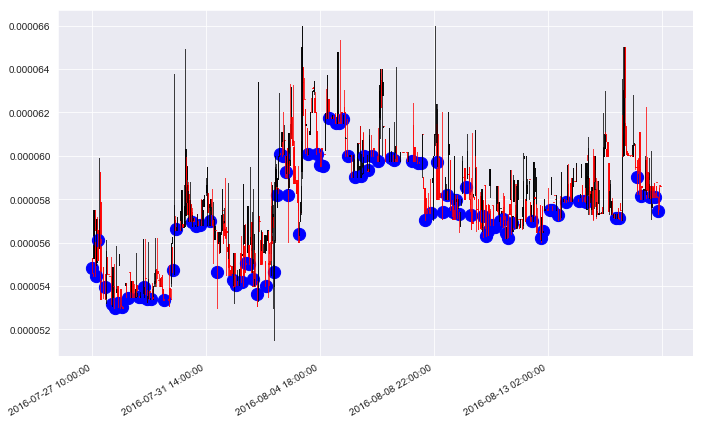

In [151]:
step = 1000
for i in range(10000, len(data), step):
    to_plot = data.iloc[i:i+step].reset_index()
    plot_ohlc_with_points(to_plot, s[['index', 'support']].values)
    break

,index,support,pair,win_size,date,max_profit,change_1,change_2,change_3,max_profit_consolidated
0,24.0000,0.0021,BTC_ETH,4,2016-01-01 12:00:00,0.0725,0.0000,0.0000,0.0000,-0.0000
1,33.0000,0.0022,BTC_ETH,4,2016-01-01 16:30:00,0.0543,0.0089,0.0000,0.0000,-0.0089
2,45.0000,0.0022,BTC_ETH,4,2016-01-01 22:30:00,0.0680,-0.0015,0.0074,0.0000,0.0015
3,58.0000,0.0022,BTC_ETH,4,2016-01-02 05:00:00,0.0441,0.0234,0.0218,0.0309,-0.0234
4,70.0000,0.0022,BTC_ETH,4,2016-01-02 11:00:00,0.0387,0.0034,0.0269,0.0253,-0.0034
5,84.0000,0.0022,BTC_ETH,4,2016-01-02 18:00:00,0.0574,-0.0173,-0.0140,0.0091,0.0173
6,94.0000,0.0022,BTC_ETH,4,2016-01-02 23:00:00,0.0688,-0.0085,-0.0257,-0.0224,0.0085
7,99.0000,0.0022,BTC_ETH,4,2016-01-03 01:30:00,0.0611,0.0007,-0.0078,-0.0250,-0.0007
8,107.0000,0.0022,BTC_ETH,4,2016-01-03 05:30:00,0.0495,0.0135,0.0143,0.0056,-0.0135
9,112.0000,0.0022,BTC_ETH,4,2016-01-03 08:00:00,0.0524,0.0010,0.0145,0.0153,-0.0010
